### Imports

In [1]:
import os
import math

import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

---

### Marginal gain oracle of the utility

In [88]:
def dppgains(K, AA, aa, detKA):
    """ Returns det(K_{A+a}) - det(K_A)
        BEING EXTREMELY CRUDE HERE,
        A more efficient way might be possible
    """
    
    Aa = np.append(AA,aa)
    KAa = np.atleast_2d(K[Aa])[:,Aa]
    
    return np.linalg.det(KAa) - detKA

In [89]:
def submodgains(X, modA, fA, aa, mixw):
    """ Returns f(A+a) - f(A)
        Where f(A) = \sum_{j=1}^m (w_j * \phi(\sum_{i \in A} X_{ij}))
    """
    
    modAa = modA + X[aa,:]
    
    # options: modA**0.5, np.log(1+modA), (1-np.exp(-modA)), modA/(1+modA)
    fAa = np.dot(mixw, modAa**0.2)
    
    return fAa - fA

### Plain old simple Greedy

In [90]:
def greedygains_logsubmod(V, X, k):
    """ For a given ground set, a feature matrix whose determinant defines the objective
        (THIS IS FOR A DPP),
        Returns the greedy selection and step-wise objective values
        Over the addition of k items
    """
    
    K = X @ X.transpose()
    n = K.shape[0]
    
    if V == None:
        V = np.arange(n)
    
    objs = np.empty(k+1)
    
    A = np.empty(0, int)
    ff = 1 # since this is a determinantal process and det(\phi) = 1
    objs[0] = ff
    
    for ii in range(k):
        
        maxgain = -100
        greedyv = np.random.choice(V)
        
        for vidx in range(len(V)):
            gain = dppgains(K, A, V[vidx], ff)
            if gain > maxgain:
                maxgain = gain
                greedyv = V[vidx]
        
        # add element to A, remove from V, update gains
        A = np.append(A, greedyv)
        V = V[V!=greedyv]
        ff += maxgain
        objs[ii+1] = ff
    
    return A, objs

In [91]:
def greedygains_submod(V, X, mixw, k):
    """ For a given ground set, a feature matrix and mixture weights which define the objective
        (submodular),
        Returns the greedy selection and step-wise objective values
        Over the addition of k items
    """
    
    K = X @ X.transpose()
    [n,m] = X.shape
    
    if V == None:
        V = np.arange(n)
    
    objs = np.empty(k+1)
    
    A = np.empty(0, int)
    modA = np.sum(X[A,:], axis=0)
    ff = 0 # assume normalized for now
    objs[0] = ff
    
    for ii in range(k):
        
        maxgain = -100
        greedyv = np.random.choice(V)
        
        for vidx in range(len(V)):
            gain = submodgains(X, modA, ff, V[vidx], mixw)
            if gain > maxgain:
                maxgain = gain
                greedyv = V[vidx]
        
        # add element to A, remove from V, update gains
        A = np.append(A, greedyv)
        modA += X[greedyv,:]
        V = V[V!=greedyv]
        ff += maxgain
        objs[ii+1] = ff
    
    return A, objs

---

### Plot gain curves

In [98]:
def objplot(objs, ground, setcolor, setcolorground=None):
    krange = np.arange(len(objs))
    
    plt.plot(krange, objs, "o", c=setcolor, label="f(S)")
    if setcolorground is not None:
        plt.plot(krange, [ground,]*len(objs), "--", c=setcolorground, label="ground set eval")
    plt.xlabel("set size")
    plt.legend(loc=2)
    

In [93]:
def logobjplot(objs, ground):
    krange = np.arange(len(objs))
    
    plt.plot(krange, np.log(objs), "o", c="purple", label="log(f(S))")
    plt.plot(krange, [np.log(ground),]*len(objs), "--", c="midnightblue", label="ground set eval")
    plt.xlabel("set size")
    plt.legend(loc=1)
    

---

### Execute for logsubmod

In [94]:
n = 50
m = 200
k = 10

np.random.seed(0)
X = np.random.random((n, m))

K = X @ X.transpose()
ground = np.linalg.det(K)

In [95]:
S, objectives = greedygains_logsubmod(None, X, k)

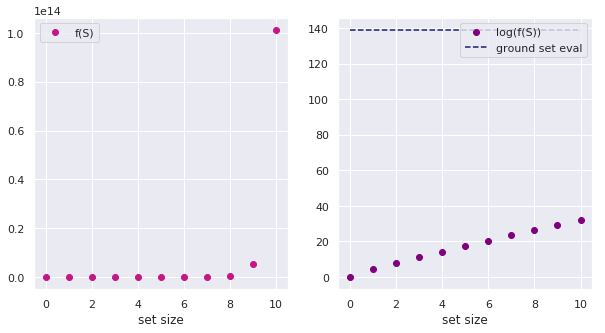

In [99]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
objplot(objectives, ground, "mediumvioletred")
plt.subplot(1,2,2)
logobjplot(objectives, ground)

In [97]:
for oo in objectives: print("{:.3f}".format(oo))

1.000
74.940
2486.709
63555.810
1487750.070
31893574.032
677766067.108
14108951137.618
276220495859.501
5396136349373.081
101255403669399.172


---

### Execute for submod

In [104]:
n = 50
m = 200
k = 10

np.random.seed(0)
X = np.random.random((n, m))
mixw = np.random.random(m); mixw = mixw/np.max(mixw)

ground = np.dot(mixw, np.sum(X, axis=0)**0.2)

In [105]:
S, objectives = greedygains_submod(None, X, mixw, k)

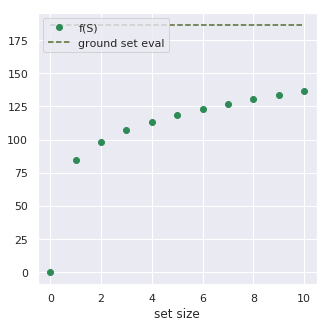

In [106]:
plt.figure(figsize=(5,5))
objplot(objectives, ground, "seagreen", "darkolivegreen")

In [108]:
for oo in objectives: print("{:.3f}".format(oo))

0.000
84.346
98.494
107.093
113.569
118.826
123.244
127.106
130.542
133.648
136.481


---

### Visualize TSNE of selection

In [110]:
def viztsne(X, S, setcolor, setlabel, perp):
    """ Given an nxm feature matrix X
        A selection of indices S of size k < n
        Plot the selection's 2d TSNE
    """
    
    [n,m] = X.shape
    Xemb = TSNE(n_components=2, random_state=256).fit_transform(X)
    
    plt.scatter(Xemb[:,0], Xemb[:,1], c="lightskyblue")
    plt.scatter(Xemb[S,0], Xemb[S,1], c=setcolor, label=setlabel)
    plt.legend()
    

---

### DPP v/s Submodular

In [112]:
n = 50
m = 200
k = 10

np.random.seed(0)
X = np.random.random((n, m))

np.random.seed(1)
mixw = np.random.random(m); mixw = mixw/np.max(mixw)

In [ ]:
S_d, objectives_d = greedygains_logsubmod(None, X, k)

In [ ]:
S_s, objectives_s = greedygains_submod(None, X, mixw, k)

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
viztsne(X, S_d, "purple", "DPP", 30)
plt.subplot(1,2,2)
viztsne(X, S_s, "seagreen", "SPP", 30)

---

### Greedy v/s WeightedGreedy

Compare:<br>
Feasibility, output quality, computational complexity.